In [11]:
import sys

sys.path.insert(0, './site-packages')

from pandas import read_excel
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import shap
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pickle


# file_name = '814_821_2020.csv' # change it to the name of your excel file
file_name = '9214_9215_2020.csv'
label = "user"

In [12]:
### read data
# df_all = pd.read_csv(file_name)
df = pd.read_csv(file_name)

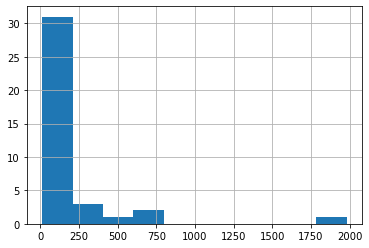

In [15]:
usergroup = df.groupby(by="user").count()
usergroup['CPU1 Temp'].hist()

In [18]:
usergroup['CPU1 Temp'].sum()

6672

In [4]:
sub_name='_hge_fmolajaf'
df = df_all[(df_all['user']=='hge') | (df_all['user']=='fmolajaf')]

In [5]:
df.groupby(by="user").count()

,CPU1 Temp,CPU2 Temp,Inlet Temp,Memory usage,Fan1 speed,Fan2 speed,Fan3 speed,Fan4 speed,Power consumption
user,,,,,,,,,
fmolajaf,495374,495374,495374,495374,495374,495374,495374,495374,491458
hge,377894,377894,377894,377894,377894,377894,377894,377894,375936


In [3]:
def create_folder(dirName): 
    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ") 
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")

In [4]:
categorical_cols = ['user']


from sklearn import preprocessing

le_dict = dict()
for c in categorical_cols:
    le = preprocessing.LabelEncoder()
    
    df[c] = le.fit_transform(df[c].astype(str))
    le_dict[c]= le


    
# today = datetime(2020, 5, 1)
# df["EVENT_DATE"] = (today - df['EVENT_DATE']).dt.days
# df["DISC_TIME"] = df['DISC_TIME'].dt.hour

In [8]:
num_classes = df[label].nunique()
print("num_classes", num_classes)


feature_cols = list(df.columns)
feature_cols.remove(label)

random_seed = 2020

early_stopping = 200
try:
    X_train, X_valid, y_train, y_valid = train_test_split(df[feature_cols], df[label], test_size=0.3, random_state=random_seed, stratify = df[label])
except:
    X_train, X_valid, y_train, y_valid = train_test_split(df[feature_cols], df[label], test_size=0.3, random_state=random_seed)

X_total = df[feature_cols]
y_total = df[label]

if num_classes == 2:
    metric = "binary_logloss"
    objective = "binary"
    eval_metric= "binary_logloss"
else:
    metric = "multi_logloss"
    objective = "multiclass"
    eval_metric= "multi_logloss"


## prepare the model
lgb_params = {
    'boosting_type':'gbdt', 'colsample_bytree':0.6,
    'importance_type':'gain', 'learning_rate':0.005, 'max_depth':5,
    'min_child_samples':10, # 'min_child_weight':0.001, 'min_split_gain':0.0,
    'n_estimators':8000, 'n_jobs': 16, 'num_leaves':20, 'subsample_freq':10,
    'seed': random_seed, 'reg_alpha':0.0, 'reg_lambda':0.0, 'silent':True,
    'subsample':0.85, 'subsample_for_bin':200000,  "metric":metric ,'objective':objective
}

lgb_model = lgb.LGBMClassifier(**lgb_params)
record_store = dict()


num_classes 2


In [ ]:
lgb_model.fit( X=X_total, y=y_total, feature_name = feature_cols, #categorical_feature = cate_cols, 
              early_stopping_rounds= early_stopping, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              eval_names=["train", "valid"],
              eval_metric= eval_metric, 
              verbose = -1, callbacks = [lgb.record_evaluation(record_store)])


pred_y = lgb_model.predict(X_total)
print("accuracy = ", accuracy_score(y_total, pred_y))

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X=X_total, y=X_total)

shap_values_np = np.array(shap_values)

shap_importance = pd.DataFrame({"feature_name": feature_cols})

class_order = lgb_model.classes_

for i, class_name in enumerate(class_order):
    shap_class_i = pd.DataFrame({"feature_name": feature_cols, class_name: np.abs(shap_values[i]).sum(axis=0)})
    shap_importance = pd.merge(shap_importance, shap_class_i, on="feature_name", how="inner")

tmp = shap_importance.drop("feature_name", 1).sum(axis=1).sort_values(ascending=True).index
shap_importance = shap_importance.reindex(tmp)

output = "output"+file_name.split('.')[0]+sub_name
create_folder(output)

with open(f'{output}/label_encoder_dict.pkl', 'wb') as handle:
    pickle.dump(le_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
shap_importance.to_csv(f"{output}/shap_variable_full.csv")

shap.summary_plot(shap_values, X_total, max_display =  len(feature_cols), show=False, 
              plot_type = "bar",
                 class_names=class_order)
plt.savefig(f"{output}/BAR_PLOT", bbox_inches='tight')
plt.close()

for i, class_name in enumerate(class_order):
    shap.summary_plot(shap_values[i], X_total, max_display =  len(feature_cols), show=False, 
              plot_type = "dot",
              class_names=lgb_model.classes_)
    plt.savefig(f"{output}/{class_name}", bbox_inches='tight')
    plt.close()
    
    print("\n")
    
print(f"Get the result at {os.getcwd()}/{output}")
        

shap_importance






Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[8000]	train's binary_logloss: 0.540054	valid's binary_logloss: 0.541019
accuracy =  0.6982976589088344


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [5]:
output = 'output'
shap_importance=pd.read_csv(f"{output}/shap_variable_full.csv",index_col = "Unnamed: 0")
ordinalColumns = shap_importance.columns.values
ordinalColumns[1:len(le_dict['user'].classes_)+1] = le_dict['user'].classes_
shap_importance.columns = ordinalColumns
num_classes = df[label].nunique()

In [6]:
shap_importance=shap_importance.sort_index()

In [7]:
shap_importance

,feature_name,abkenyon,adegbalo,akitazum,bdankesr,bjayee,daray,ddocimo,edgardga,emilwrig,...,qiu25856,rafiisla,rmanser,shahrahm,stalukde,svaca,tobollin,twixtrom,wan39502,war94577
0,CPU1 Temp,359.179208,4406.777994,1159.737036,6905.980574,1316.482731,987.819947,909.821581,3036.462344,3992.455090,...,978.097758,1816.528408,3096.287709,3399.549130,1926.274432,1230.077940,627.083206,2163.180371,2503.026589,5415.787941
1,CPU2 Temp,796.822288,2742.675260,669.366462,2347.885997,398.923879,682.220094,554.965254,1206.706047,1786.310065,...,959.913193,4414.668244,3743.693911,2283.868674,5368.136511,2286.168629,948.584421,2017.913126,2469.881517,1797.644255
2,Inlet Temp,764.115457,376.838915,76.770327,1437.269734,770.716647,508.268271,1069.957649,646.482012,1388.929712,...,464.161995,1046.895966,1676.459320,984.715615,924.306752,102.086276,775.353741,1290.243166,374.919350,578.055368
3,Memory usage,2409.389432,4212.410547,1943.952821,2865.542024,1540.204598,1972.306243,3844.406867,1026.182607,3603.676523,...,2084.609097,3325.858626,5134.574801,4769.764480,3674.599015,2248.833277,2844.655734,974.717378,4063.302840,3386.705597
4,Fan1 speed,481.678698,1400.592301,189.980154,965.681315,303.853640,1003.302544,1936.604532,1410.054583,925.001630,...,787.904285,861.553937,1078.855626,770.410776,805.322010,585.885902,432.521703,507.064199,506.052550,635.766754
5,Fan2 speed,863.969417,529.402801,207.832865,2007.686267,905.779578,838.424541,2163.016195,1533.702814,1433.599485,...,849.161605,680.431092,505.393772,824.649680,730.314294,406.952908,713.212880,566.504311,704.895223,353.318460
6,Fan3 speed,661.900224,813.249012,83.720540,967.498830,1024.249209,231.346352,390.204539,1510.211733,2004.099337,...,239.427088,832.463890,554.445951,996.970644,1152.711492,1278.378068,447.485067,1062.663439,579.398198,931.563082
7,Fan4 speed,194.137806,885.573016,64.347015,1183.104718,1277.849272,862.782948,329.915350,2008.720478,1714.938845,...,796.909663,933.300238,698.172653,453.746236,300.968382,510.656786,215.987193,642.292106,578.140091,169.615752
8,Power consumption,1114.446307,9318.786071,1535.168157,6802.689360,2604.148314,3225.974641,2644.291220,5307.325223,2772.177203,...,3262.119132,3708.718946,11162.858391,4238.378900,10317.313872,2160.365930,1168.766251,1102.845461,5831.566962,1892.129252


In [10]:
shap_importance.to_csv(f'projection/src/data/{file_name}',index=False)

In [ ]:
import plotly.graph_objects as go
x = shap_importance.columns.values[1:len(shap_importance.columns.values)]

fig = go.Figure()
for i in range(shap_importance.shape[0]):
    fig.add_trace(go.Bar(x=x, y=shap_importance.iloc[i, 1:], name=shap_importance.iloc[i, 0]))


fig.update_layout(barmode='relative', title_text='Feature importance for each user, colored by health metrics',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='User',
    ))
fig.show()


In [ ]:
import plotly.offline as pyo
pyo.plot(fig, filename=f"{output}/{file_name.split('.')[0]}_UservsMetric.html")

In [ ]:
import plotly.graph_objects as go
x = shap_importance['feature_name']

fig = go.Figure()
label = shap_importance.columns.values
for i in range(1,len(shap_importance.columns.values)):
    fig.add_trace(go.Bar(x=x, y=shap_importance.iloc[0:, i], name=label[i]))


fig.update_layout(barmode='relative', title_text='Feature importance for each Health metric, colored by users',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Health metrics',
    ))
fig.show()


In [ ]:
import plotly.offline as pyo
pyo.plot(fig, filename=f"{output}/{file_name.split('.')[0]}_Metricvsuser.html")